In [75]:
### Import functions from modules
%reload_ext autoreload
%autoreload 225d
from pretreatment_methods import *
from w2v_feats_adding import *

Using TensorFlow backend.


In [76]:
pre_local="data/"
pre_remote="data/"
train_data=TwitterSentimentData(loc_data=pre_local,pre_cleaned=False,is_test_file=False,sep="")
test_data=TwitterSentimentData(loc_data=pre_local,pre_cleaned=False,is_test_file=True)

/home/jlevyabi/seacabo/fempl_big_sim/sent_class/pretreatment_methods.py:22: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  d_neg=pd.read_csv(loc_data+"train_neg"+sep+".txt",sep='\tñ',header=None);d_neg.columns=["text"]
/home/jlevyabi/seacabo/fempl_big_sim/sent_class/pretreatment_methods.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  d_pos=pd.read_csv(loc_data+"train_pos"+sep+".txt",sep='\tñ',header=None);d_pos.columns=["text"]


In [77]:
# Clean Data
complete_data=TwitterAddTextData(train_data,1,1,1,1,1,1,1)
complete_data.add_text_features()
cleaned=TwitterDataCleaning(complete_data)
sentiment_data=SentimentAnalysis(cleaned)

In [15]:
full_data=Tweets_w2v_Features(pre_filled_feats=cleaned.info,built_w2v=pre_remote+"word2vec_twitter_model.bin")

2017-12-20 17:12:34,049 : INFO : loading projection weights from /datastore/complexnet/jlevyabi/network_representation/data_files/w2v_files/word2vec_twitter_model/word2vec_twitter_model.bin
2017-12-20 17:19:39,576 : INFO : loaded (3039345, 400) matrix from /datastore/complexnet/jlevyabi/network_representation/data_files/w2v_files/word2vec_twitter_model/word2vec_twitter_model.bin


In [ ]:
full_data.sp_features(min_times=5,nb_clusts=30)

  0%|          | 0/45611 [00:00<?, ?it/s]

Nb words in vocabulary.... 47056
Computing similarity matrix .....


100%|██████████| 45611/45611 [00:00<00:00, 142911.65it/s]


In [7]:
full_data.nlm_features()

In [8]:
def get_embedding(embed_name,df):
    dim_total=len((df.head(1)[embed_name][0]))
    return np.array(np.vstack([sample[0]
                      for it,sample in (df[[embed_name]].iterrows())]))

In [9]:
w2v_fts=get_embedding("w2v",full_data.info.data[full_data.info.data['w2v'].isnull()== False])
cfd_fts=get_embedding("cfd",full_data.info.data[full_data.info.data['w2v'].isnull()== False])
shallow=["number_of_uppercases","number_of_exclamations","number_of_questions","number_of_sights",
         "number_of_hashtags","number_of_mentions","number_of_urls"]
shallow_fts=full_data.info.data[full_data.info.data['w2v'].isnull()== False][shallow]

In [10]:
target=full_data.info.data[full_data.info.data['w2v'].isnull()== False]["pos_sent"]
fts=np.hstack([w2v_fts,cfd_fts,shallow_fts])

In [108]:
target_two_cols=np.transpose(np.vstack([target,target]))
target_two_cols[target_two_cols[:,0]==-1,0]=0
target_two_cols[target_two_cols[:,1]==1,1]=0
target_two_cols=np.abs(target_two_cols)

from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test=train_test_split(fts,target_two_cols)

## Deep Neural Network: Simple

In [ ]:
import numpy as np
import os
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Nadam, Adagrad, Adadelta, Adam, Adamax

def build_model(input_dim, nb_class):
    units=[input_dim//2,input_dim//4,input_dim//4,input_dim//10,input_dim//50]
    model = Sequential()
    model.add(Dense(input_dim=input_dim, units=units[0], activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(input_dim=units[0], units=units[1], activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(input_dim=units[1], units=units[2], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(input_dim=units[2], units=units[3], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(input_dim=units[3], units=units[4], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim=nb_class, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adadelta')
    return model

checkpointer = ModelCheckpoint(filepath='/home/jlevyabi/seacabo/fempl_big_sim/sent_class/checkpt_data/weights.hdf5',
                               verbose=1, save_best_only=True)
tf_model=build_model(input_dim=X_train.shape[1],nb_class=2)
tf_model.fit(X_train, y_train, batch_size=100, epochs=1000, verbose=2)
score = tf_model.evaluate(X_test, y_test, batch_size=1000)

In [ ]:
             precision    recall  f1-score   support

          0       0.85      0.83      0.84     24800
          1       0.83      0.85      0.84     24435

avg / total       0.84      0.84      0.84     49235

## TSNE Visualizations

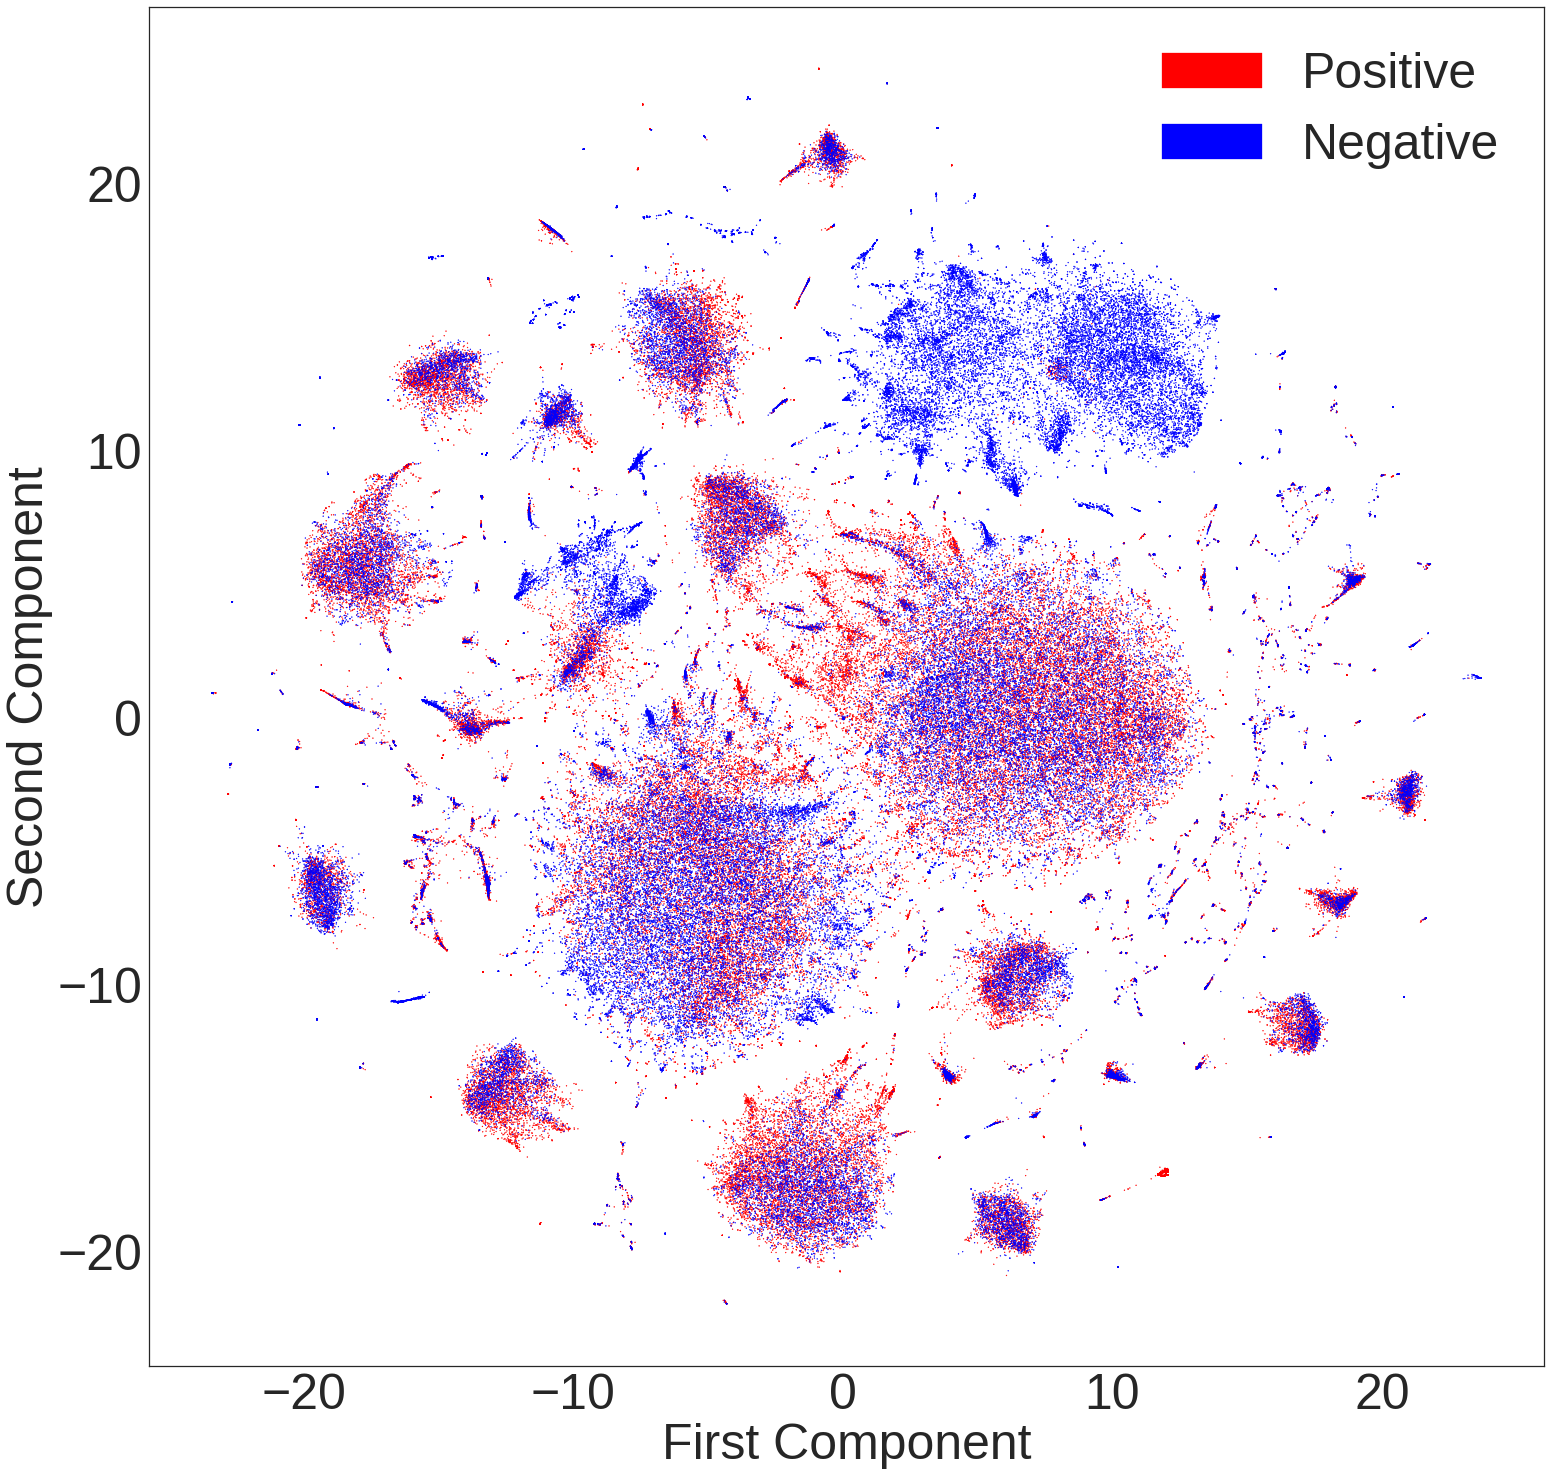

In [107]:
import pickle
dic_tsne=pickle.load(open("/home/jlevyabi/seacabo/fempl_big_sim/sent_class/checkpt_data/dic_tsne_full.p","rb"))
fts_target=dic_tsne["fts_target"]
targets=dic_tsne["sent_target"]

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches


f=plt.figure(figsize=(25,25))
col_target=targets.copy()
col_target[col_target==1]="red"
col_target[col_target==-1]="blue"
s=50
plt.scatter(x=fts_target[:,0],y=fts_target[:,1],c=col_target,s=1)
plt.plot([0],[0],'.',c="red",label="Positive")
plt.plot([0],[0],'.',c="blue", label="Negative")
plt.xlabel("First Component", size=s)
plt.ylabel("Second Component", size=s)
plt.xticks(fontsize=s)
plt.yticks(fontsize=s)
red_patch = mpatches.Patch(color='red', label='Positive')
blue_patch = mpatches.Patch(color='blue', label='Negative')
                            
legend=plt.legend(handles=[red_patch,blue_patch],prop={'size':s})
f.savefig('tweets_tsne.png')
plt.show()

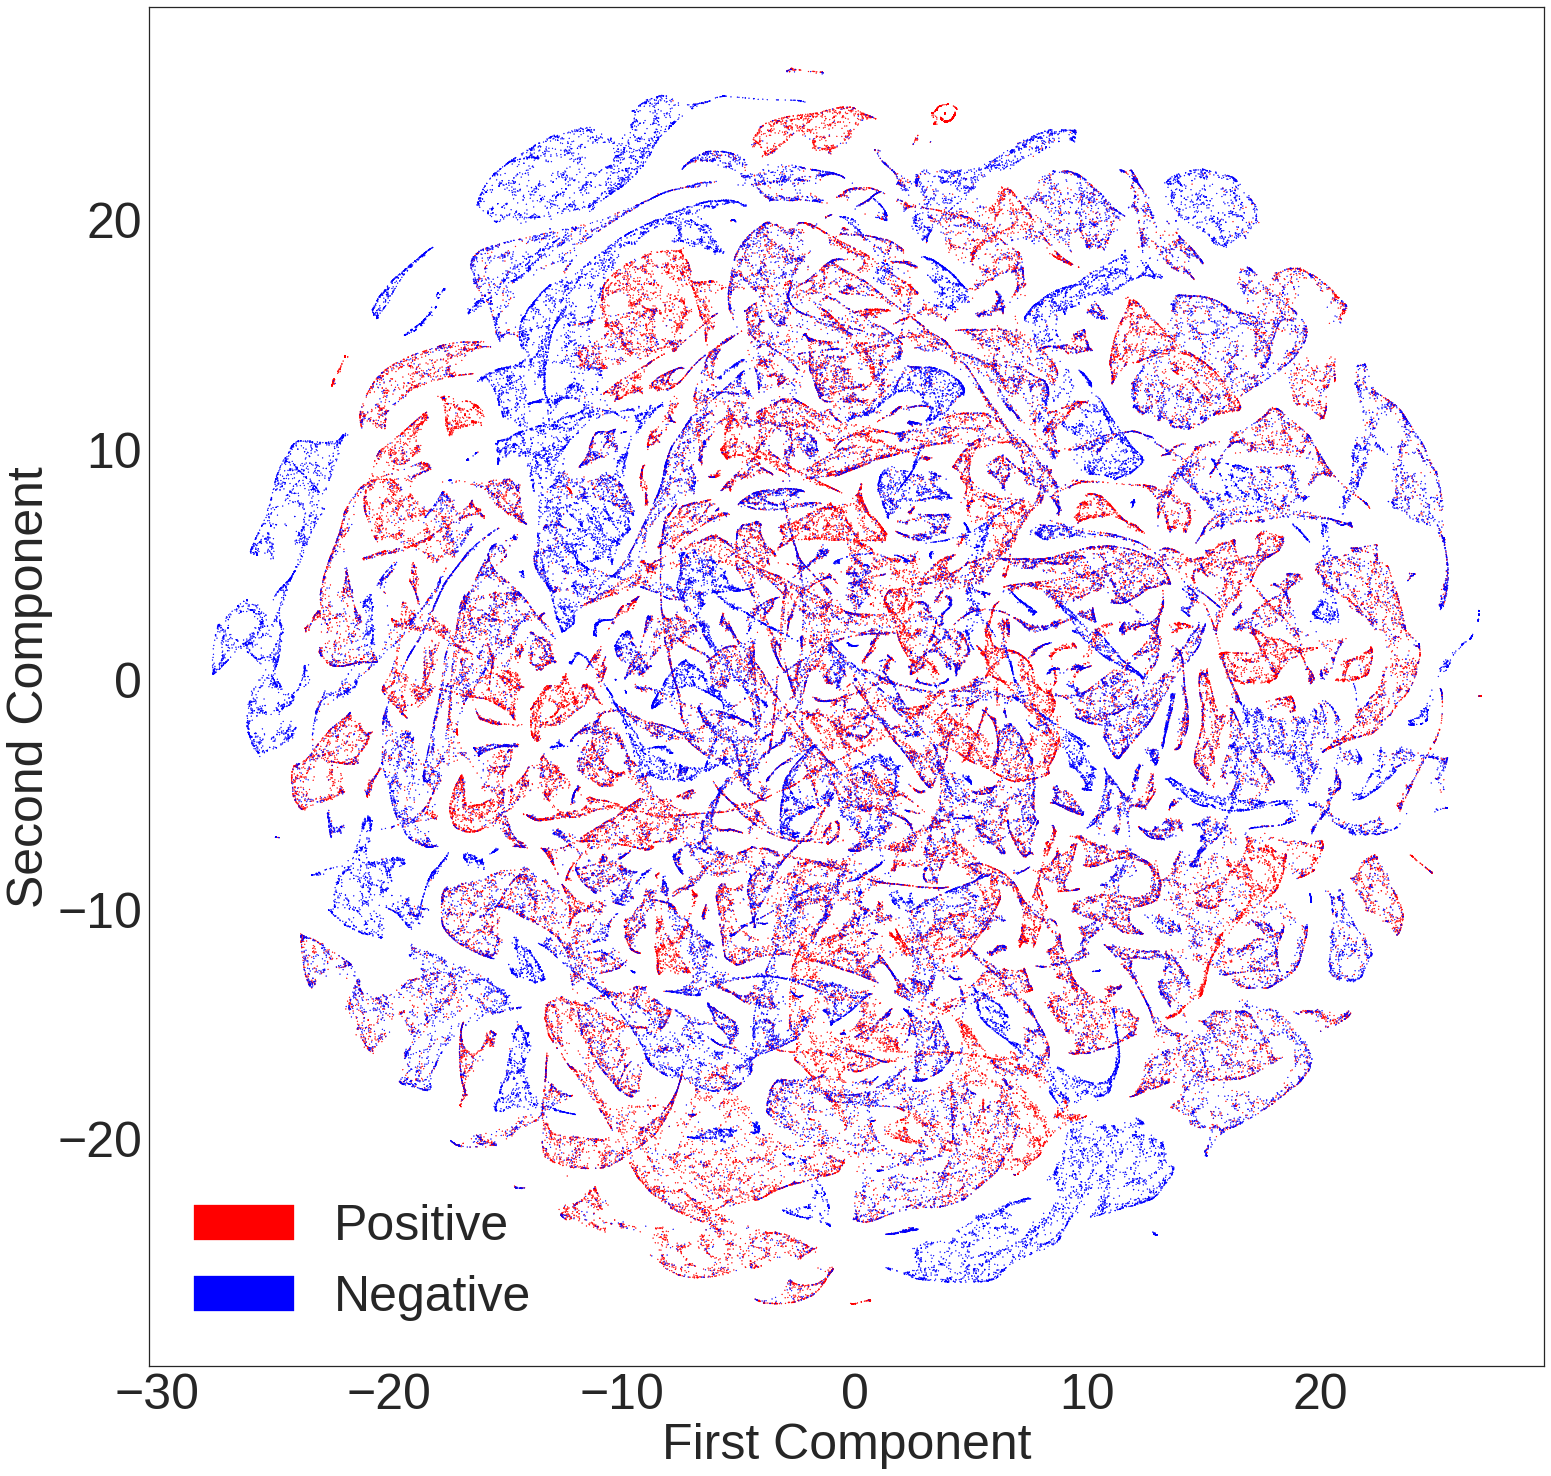

In [105]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches



import pickle
d=pickle.load(open("inter_tsne_plt.p","rb"))
X=d['pos'];targets=d['target']

f=plt.figure(figsize=(25,25))
col_target=(targets).copy()
col_target[col_target==1]="red"
col_target[col_target==-1]="blue"
s=50
plt.scatter(x=X[:,0],y=X[:,1],c=col_target,s=1)
plt.plot([0],[0],'.',c="red",label="Positive")
plt.plot([0],[0],'.',c="blue", label="Negative")
plt.xlabel("First Component", size=s)
plt.ylabel("Second Component", size=s)
plt.xticks(fontsize=s)
plt.yticks(fontsize=s)
red_patch = mpatches.Patch(color='red', label='Positive')
blue_patch = mpatches.Patch(color='blue', label='Negative')
                            
legend=plt.legend(handles=[red_patch,blue_patch],prop={'size':s})
f.savefig('non_tweets_tsne.png')
plt.show()

/home/jlevyabi/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


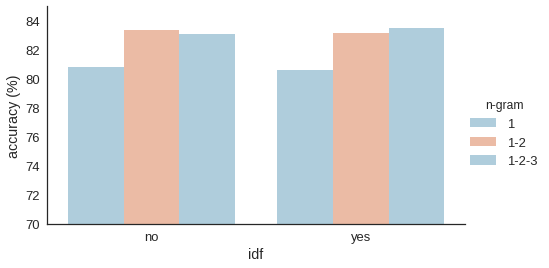

In [64]:
sns.set(font_scale=1.3,)
sns.set_style('white')
g = sns.factorplot(x="idf", y="accuracy",hue="n-gram", data=d, kind="bar", size=4, aspect=1.7,palette=sns.color_palette("RdBu_r", 4))
sns.plt.ylim([70,85])
sns.plt.ylabel("accuracy (%)")
sns.plt.savefig("idf.pdf")
sns.plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(usrs_with_insee_income.income,bins=50,histtype='bar', rwidth=0.8)
plt.show()